In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sns.set_theme(style="whitegrid", font_scale=1.1)

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
lion_king_data = processed_data[(processed_data['movie_name'] == 'The Lion King') & (processed_data['year'] == '1994')].dropna(subset=['rating'])

In [41]:

# stat counts for each group
variance_table = lion_king_data.groupby('are_you_an_only_child')['rating'].agg(['count', 'mean', 'median', 'var', 'std']).reset_index()
print(variance_table)

   are_you_an_only_child  count      mean  median       var       std
0                   -1.0     10  3.450000     4.0  0.858333  0.926463
1                    0.0    776  3.481959     4.0  0.515803  0.718194
2                    1.0    151  3.347682     3.5  0.666645  0.816483


In [42]:
lion_king_data = lion_king_data[lion_king_data['are_you_an_only_child'] != -1.0] # remove NA values

In [43]:
# treat rating as ordinal variable
lion_king_data['rating'] = pd.Categorical(lion_king_data['rating'], ordered=True)
only_child_group = lion_king_data[lion_king_data['are_you_an_only_child'] == 1]["rating"]
not_only_child_group = lion_king_data[lion_king_data['are_you_an_only_child'] == 0]["rating"]

not_only_child_group


220       4.0
1420      3.0
2620      3.5
3020      4.0
3420      4.0
         ... 
436220    3.5
436620    4.0
437020    3.5
437420    3.5
438620    4.0
Name: rating, Length: 776, dtype: category
Categories (9, float64): [0.0 < 0.5 < 1.0 < 1.5 ... 2.5 < 3.0 < 3.5 < 4.0]

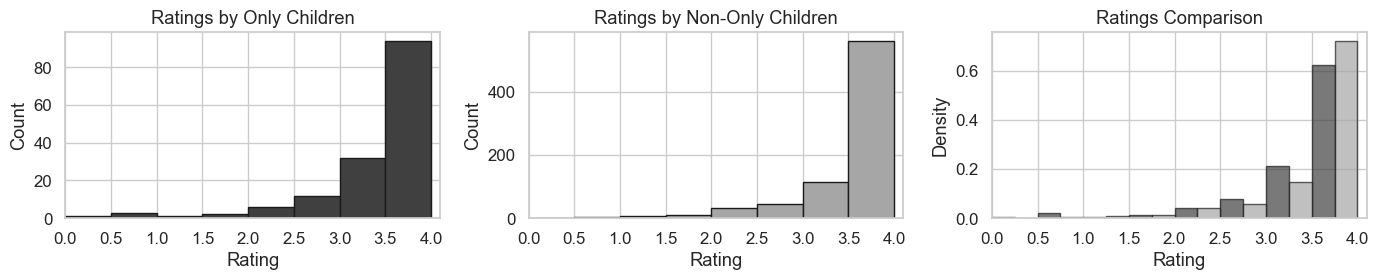

In [75]:
import numpy as np
import matplotlib.pyplot as plt


# bins and centers (ratings 1–4 in 0.5 steps)
bin_edges  = np.arange(0, 4.5, 0.5)                  # [1.0, 1.5, ..., 4.5]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2   # [1.25, 1.75, ..., 3.75]
xticks = np.arange(0, 4.01, 0.5)

# counts per bin
counts_only, _ = np.histogram(only_child_group, bins=bin_edges)
counts_not,  _ = np.histogram(not_only_child_group, bins=bin_edges)

# bar layout
width = 0.5
fig, ax = plt.subplots(1, 3, figsize=(14, 3))

ax[0].bar(bin_centers, counts_only, width=width, label="Only Child", color="0.25", edgecolor="0.1")
ax[1].bar(bin_centers, counts_not,  width=width, label="Not Only Child", color="0.65", edgecolor="0.1")

# labels & axes
ax[0].set_title("Ratings by Only Children")
ax[1].set_title("Ratings by Non-Only Children")
for a in ax:
    a.set_xlabel("Rating")
    a.set_ylabel("Count")
    a.set_xticks(xticks)
    a.set_xlim(0, 4.1)
    
# combined plot for density comparison
counts_only = counts_only / counts_only.sum()
counts_not  = counts_not  / counts_not.sum()

ax[2].bar(bin_centers - width/4, counts_only, width=width/2, label="Only Child", color="0.25", edgecolor="0.1", alpha=0.7)
ax[2].bar(bin_centers + width/4, counts_not,  width=width/2, label="Not Only Child", color="0.65", edgecolor="0.1", alpha=0.7)
ax[2].set_title("Ratings Comparison")
ax[2].set_xlabel("Rating")
ax[2].set_ylabel("Density")
ax[2].set_xticks(xticks)
ax[2].set_xlim(0, 4.1)

plt.tight_layout()

plt.savefig("../figures/lion_king_only_child_rating_distribution.pdf", dpi=300)


In [ ]:
before_dropping_na = lion_king_data['are_you_an_only_child'].value_counts()

# stat counts for each group
variance_table = lion_king_data.groupby('are_you_an_only_child')['rating'].agg(['count', 'mean', 'median', 'var', 'std']).reset_index()
print(variance_table)

   are_you_an_only_child  count      mean  median       var       std
0                   -1.0     10  3.450000     4.0  0.858333  0.926463
1                    0.0    776  3.481959     4.0  0.515803  0.718194
2                    1.0    151  3.347682     3.5  0.666645  0.816483


# Inferences

Mann–Whitney U test (a non-parametric test comparing the central tendency/rank distributions of two groups).

Null hypothesis (H0):
The rating distributions for only children and non-only children are the same.

Alternative hypothesis (H1):
Only children tend to give higher ratings than non-only children.

In [26]:

# perform Wilcoxon rank-sum test (Mann-Whitney U test)
# H0: The distributions of ratings for only children and non-only children are the same.
# H1: The distribution of ratings for only children is greater than that for non-only children
t_stat, p_value = stats.mannwhitneyu(
    only_child_group['rating'],
    not_only_child_group['rating'],
    alternative='greater',
    use_continuity=False
)

print(f"Wilcoxon rank-sum test results on ratings: statistic = {t_stat}, p-value = {p_value}")

Wilcoxon rank-sum test results on ratings: statistic = 52929.0, p-value = 0.9784098654550833


We performed a one-sided Wilcoxon rank-sum (Mann–Whitney U) test to assess whether only-child participants tend to assign higher ratings than non-only-child participants. The test statistic was U = 52,929, p = 0.978, leads us to not be able to drop the null.

### Opposite Direction Check
To explore the reverse hypothesis, let our alternative hypothesis now be only-child ratings are lower than non-only-child ratings. 

In [27]:

t_stat, p_value = stats.mannwhitneyu(
    only_child_group['rating'],
    not_only_child_group['rating'],
    alternative='less',
    use_continuity=False
)

print(f"Wilcoxon rank-sum test results on ratings: statistic = {t_stat}, p-value = {p_value}")

Wilcoxon rank-sum test results on ratings: statistic = 52929.0, p-value = 0.021590134544916692


The one-sided test returned U=52,929, p=0.0216. Since we are effectively testing two directional hypotheses, our overall significance threshold should be adjusted for multiple comparisons:

alpha_total = 0.005 + 0.005 = 0.01

Even under this relaxed two-sided equivalent, p=0.0216>0.01, so the result remains not statistically significant.

At the adjusted alpha = 0.01 level, we still fail to reject the null hypothesis.
There is no statistically meaningful difference in how only-child and non-only-child participants rate movies.